In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
import config
import process_data

In [2]:
# define ivim function
def ivim(b, Dp, Dt, Fp):
    return Fp*np.exp(-b*Dp) + (1-Fp)*np.exp(-b*Dt)

# apply mask: only keep vox with mask = 1

**Single subject Data 100206**

In [3]:
scan = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [4]:
mask = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [5]:
scan_dimension = scan.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [6]:
print(x, y, z, b)

print('The shape of scan: ')
print(scan.shape)
print('The shape of mask: ')
print(mask.shape)

print(type(scan), type(mask))

145 174 145 288
The shape of scan: 
(145, 174, 145, 288)
The shape of mask: 
(145, 174, 145)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [7]:
scan_long = np.reshape(scan, (x*y*z, b))

In [8]:
mask_long = np.reshape(mask, (x*y*z, 1))

In [15]:
scan_long_no_background = process_data.trim_background(scan_long, mask_long)

In [16]:
scan_long_no_background.shape

(936256, 288)

In [18]:
scan_long_no_bg_cp = scan_long_no_background

In [19]:
# Ignore all strange data

def find_rows_beginning_with_zero(scan_long_no_bg):
    return np.where(scan_long_no_bg[:, 0] == 0)[0]

Sb_beginning_0 = find_rows_beginning_with_zero(scan_long_no_background)
scan_long_no_bg = np.delete(scan_long_no_background, Sb_beginning_0, 0)

print(scan_long_no_bg.shape)
print(scan_long_no_background.shape)

(935442, 288)
(936256, 288)


In [ ]:
# Ignore data that leads to S0 in [0, 1)

# bval_list = np.loadtxt(config.data_folder2 + '/100206/bvals')
# S0 = process_data.get_S0(scan_long_no_background, bval_list)
# error_voxels = np.argwhere(np.logical_and(S0 >= 0, S0 < 1))[:,0]
# scan_long_no_bg = np.delete(scan_long_no_background, error_voxels, 0)
# S0_ = np.delete(S0, error_voxels, 0)
# np.save('S0_2.npy',S0_)

In [3]:
bval_list = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [21]:
S0 = process_data.get_S0(scan_long_no_bg, bval_list)
# S0 = np.load('S0_1.npy')

In [22]:
S0.shape

(935442, 1)

In [24]:
normalized_scan_long_no_background = process_data.normalize_scan(scan_long_no_bg, S0)

In [4]:
# np.save('normalized_scan_long_2.npy', normalized_scan_long_no_background)
normalized_scan_long_no_background = np.load('normalized_scan_long_1.npy')

In [32]:
# normalized_scan_long_no_background.shape
Ab_voxels = np.argwhere(np.logical_and(S0 >= 0, S0 < 1))[:,0]
print(Ab_voxels)

[229768 536137 850262]


In [33]:
scan_long_no_bg

array([[587.17718506, 358.32980347, 231.72703552, ..., 299.55273438,
        255.15158081, 142.32798767],
       [507.74441528, 209.08628845, 260.41522217, ..., 203.17358398,
        306.38717651, 163.31565857],
       [487.08456421, 222.9410553 , 164.82409668, ..., 173.70411682,
        261.70492554, 141.86515808],
       ...,
       [812.58972168, 293.08770752, 151.81272888, ..., 234.93511963,
        148.44284058, 252.454422  ],
       [611.19360352, 356.01541138, 282.81274414, ..., 197.86349487,
        240.8157196 , 113.83872986],
       [881.83642578, 131.84002686, 136.59486389, ..., 252.69070435,
        327.61587524, 269.12463379]])

In [35]:
print(normalized_scan_long_no_background.shape)
print(S0.shape)

(935439, 288)
(935442, 1)


In [36]:
np.argwhere(normalized_scan_long_no_background>10)

array([[117489,      4],
       [117489,     20],
       [117489,     60],
       ...,
       [784703,    214],
       [784703,    231],
       [838711,     90]])

In [37]:
np.unique(bval_list)

array([   5.,  990.,  995., 1000., 1005., 1985., 1990., 1995., 2000.,
       2005., 2010., 2980., 2985., 2990., 2995., 3000., 3005., 3010.])

## Neural Network Training

Let's create the neural network class and instantiate it.

In [5]:
class Net(nn.Module):
    def __init__(self, b_values_no0):
        super(Net, self).__init__()

        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), 3))

    def forward(self, X):
        # print('x')
        # print(X.shape)
        params = torch.abs(self.encoder(X)) # Dp, Dt, Fp
        # print(params.shape)
        # print(params)
        Dp = params[:, 0].unsqueeze(1)
        Dt = params[:, 1].unsqueeze(1)
        Fp = params[:, 2].unsqueeze(1)

        X = Fp*torch.exp(-self.b_values_no0*Dp) + (1-Fp)*torch.exp(-self.b_values_no0*Dt)

        return X, Dp, Dt, Fp

In [6]:
net = Net(bval_list)
print(net)

Net(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=3, bias=True)
  )
)


In [7]:
# Network
b_values = torch.FloatTensor(bval_list)
net = Net(b_values)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.000001)  

Create batch queues.

In [8]:
batch_size = 128
num_batches = len(normalized_scan_long_no_background) // batch_size
# X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_long_no_background.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)

In [14]:
net2 = Net(b_values)

Train, this might take a few minutes.

In [ ]:
# epoch, lr, layer, data size increase

In [9]:
loss_arr=[]

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 15

# Train
counter = 0
for epoch in range(1000): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # print('Running_loss: ', running_loss)
        # print('X_batch: ')
        # print(X_batch.shape)
        # print(X_batch)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
        # print('X_pred: ')
        # print(X_pred.shape)
        # print(X_pred)
        if i == 8 and counter == 10:
            print('X_batch: ')
            print(X_batch)
            print('X_pred: ')
            print(X_pred)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        # print('loss: ', loss.item())
        running_loss += loss.item()
        
    loss_arr.append(running_loss)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/len(trainloader)))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
# Restore best model
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.79it/s]


Loss: 1126.1373540386558
Average Loss: 0.15409651806768687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.79it/s]


Loss: 1079.6484746485949
Average Loss: 0.1477351497877114
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.11it/s]


Loss: 1002.36807911098
Average Loss: 0.13716038302011221
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.20it/s]


Loss: 968.0229279473424
Average Loss: 0.13246071810992643
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.65it/s]


Loss: 953.327787257731
Average Loss: 0.1304498887873195
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.45it/s]


Loss: 942.2021318003535
Average Loss: 0.12892749477290005
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.16it/s]


Loss: 930.6506746634841
Average Loss: 0.12734683561350357
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.16it/s]


Loss: 912.1648793555796
Average Loss: 0.1248173069725752
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.36it/s]


Loss: 899.6684636883438
Average Loss: 0.12310734314290418
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.67it/s]


Loss: 883.4532210603356
Average Loss: 0.12088850862894576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  1%|▌                                                                                                       | 42/7308 [00:02<04:03, 29.82it/s]

X_batch: 
tensor([[1.0010, 0.3939, 0.2615,  ..., 0.3726, 0.2764, 0.1264],
        [0.9655, 0.5302, 0.2321,  ..., 0.4997, 0.3427, 0.1457],
        [0.9834, 0.1501, 0.0628,  ..., 0.1689, 0.0644, 0.0405],
        ...,
        [1.0940, 0.2282, 0.1547,  ..., 0.2065, 0.1136, 0.0449],
        [1.0303, 0.3981, 0.2230,  ..., 0.5621, 0.2182, 0.1223],
        [1.0064, 0.6372, 0.3355,  ..., 0.4604, 0.5079, 0.2586]])
X_pred: 
tensor([[9.7813e-01, 2.3613e-02, 9.7631e-04,  ..., 2.3225e-02, 9.7631e-04,
         4.1434e-05],
        [9.8222e-01, 7.0254e-02, 9.0668e-03,  ..., 6.9507e-02, 9.0668e-03,
         1.1872e-03],
        [9.7184e-01, 4.8595e-02, 6.5000e-03,  ..., 4.8100e-02, 6.5000e-03,
         8.5642e-04],
        ...,
        [9.8637e-01, 8.1752e-02, 9.8173e-03,  ..., 8.0826e-02, 9.8173e-03,
         1.3557e-03],
        [9.9755e-01, 6.5428e-01, 4.8138e-01,  ..., 6.5310e-01, 4.8138e-01,
         3.8254e-01],
        [9.9483e-01, 4.2591e-01, 2.3688e-01,  ..., 4.2444e-01, 2.3688e-01,
         1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.80it/s]


Loss: 869.2282703779638
Average Loss: 0.11894201838778924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.27it/s]


Loss: 855.3309210464358
Average Loss: 0.11704035591768416
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.62it/s]


Loss: 845.9614945352077
Average Loss: 0.11575827785101366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.70it/s]


Loss: 831.754032548517
Average Loss: 0.11381418069903079
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.70it/s]


Loss: 825.5091862566769
Average Loss: 0.11295965876528145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.79it/s]


Loss: 805.9327191263437
Average Loss: 0.11028088657995946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.98it/s]


Loss: 791.1484509948641
Average Loss: 0.10825786138408103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.43it/s]


Loss: 781.9866185616702
Average Loss: 0.10700418973202931
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.10it/s]


Loss: 759.1246166806668
Average Loss: 0.10387583698421823
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.96it/s]


Loss: 754.9804405011237
Average Loss: 0.10330876306802458
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.42it/s]


Loss: 728.9212224856019
Average Loss: 0.09974291495424219
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.16it/s]


Loss: 724.3700932767242
Average Loss: 0.09912015507344338
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.31it/s]


Loss: 712.25507879816
Average Loss: 0.09746238078792556
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.65it/s]


Loss: 689.8433706946671
Average Loss: 0.09439564459423469
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.62it/s]


Loss: 688.1173804458231
Average Loss: 0.09415946639926424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.88it/s]


Loss: 662.2672832757235
Average Loss: 0.09062223361736774
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.06it/s]


Loss: 642.4299666453153
Average Loss: 0.08790776774019092
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.73it/s]


Loss: 612.141941845417
Average Loss: 0.08376326516768158
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.91it/s]


Loss: 596.5925157740712
Average Loss: 0.08163553855693366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.52it/s]


Loss: 585.7568316012621
Average Loss: 0.08015282315288207
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.79it/s]


Loss: 593.3828494716436
Average Loss: 0.08119633955550679
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.86it/s]


Loss: 578.0781812695786
Average Loss: 0.07910210471669112
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.66it/s]


Loss: 630.1485457504168
Average Loss: 0.08622722300908824
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.67it/s]


Loss: 572.6601475523785
Average Loss: 0.07836072079260789
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.92it/s]


Loss: 552.1331805568188
Average Loss: 0.07555188568100969
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.71it/s]


Loss: 549.2129044570029
Average Loss: 0.07515228577682032
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.00it/s]


Loss: 592.914865590632
Average Loss: 0.08113230235230322
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.82it/s]


Loss: 541.0531665156595
Average Loss: 0.07403573707110832
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.99it/s]


Loss: 541.5837197978981
Average Loss: 0.07410833604240533
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.16it/s]


Loss: 535.954241681844
Average Loss: 0.07333801883988013
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.99it/s]


Loss: 533.6417075698264
Average Loss: 0.07302158012723405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.59it/s]


Loss: 533.6592296184972
Average Loss: 0.07302397778030886
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.71it/s]


Loss: 535.2649081130512
Average Loss: 0.07324369295471418
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.55it/s]


Loss: 585.4651226466522
Average Loss: 0.0801129067660991
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.12it/s]


Loss: 533.0385964312591
Average Loss: 0.0729390526041679
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.65it/s]


Loss: 562.1495294696651
Average Loss: 0.07692248624379654
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.58it/s]


Loss: 541.1519523258321
Average Loss: 0.07404925456018502
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.72it/s]


Loss: 527.0038710846566
Average Loss: 0.07211328285230659
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.82it/s]


Loss: 527.4605972515419
Average Loss: 0.07217577959107033
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.66it/s]


Loss: 529.2366257128306
Average Loss: 0.07241880483207862
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.79it/s]


Loss: 538.2206827555783
Average Loss: 0.07364815034969599
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.52it/s]


Loss: 564.1638311678544
Average Loss: 0.07719811592335173
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.11it/s]


Loss: 535.1565568819642
Average Loss: 0.07322886656841328
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.14it/s]


Loss: 547.5182832367718
Average Loss: 0.07492040000503172
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.39it/s]


Loss: 527.4963931296952
Average Loss: 0.07218067776815752
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.38it/s]


Loss: 665.704995054286
Average Loss: 0.09109263752795374
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.67it/s]


Loss: 531.1084801782854
Average Loss: 0.07267494255313155
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.76it/s]


Loss: 524.4178064349107
Average Loss: 0.07175941522097848
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.06it/s]


Loss: 538.1865492500365
Average Loss: 0.07364347964559886
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.89it/s]


Loss: 519.0956924892962
Average Loss: 0.07103115660773074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.87it/s]


Loss: 530.6721307761036
Average Loss: 0.07261523409634696
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.00it/s]


Loss: 531.4591469904408
Average Loss: 0.07272292651757536
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.17it/s]


Loss: 523.7414140440524
Average Loss: 0.07166686015928467
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.72it/s]


Loss: 529.6333334981464
Average Loss: 0.07247308887495162
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.15it/s]


Loss: 528.6855717352591
Average Loss: 0.07234340062058828
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.11it/s]


Loss: 532.2791084442288
Average Loss: 0.07283512704491363
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.55it/s]


Loss: 537.9254062753171
Average Loss: 0.07360774579574672
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.53it/s]


Loss: 520.774840359576
Average Loss: 0.07126092506288671
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.95it/s]


Loss: 654.2674510609359
Average Loss: 0.08952756582661958
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.24it/s]


Loss: 578.7230563168414
Average Loss: 0.07919034706032313
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.68it/s]


Loss: 547.0178104280494
Average Loss: 0.07485191713574842
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.97it/s]


Loss: 589.6078366013244
Average Loss: 0.08067978059678768
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.80it/s]


Loss: 539.3373976261355
Average Loss: 0.07380095752957519
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.91it/s]


Loss: 520.1331451889127
Average Loss: 0.07117311784194208
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.12it/s]

Loss: 550.1464909184724
Average Loss: 0.07528003433476634
Done, best loss: 519.0956924892962
Done


<All keys matched successfully>

In [10]:
len(loss_arr)

75

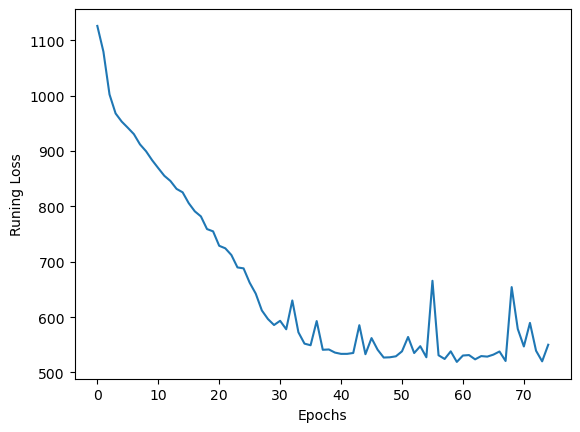

In [12]:
epoch_arr = np.arange(0, 75)
loss_arr = np.array(loss_arr)
plt.plot(epoch_arr, loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Runing Loss")
plt.show()

In [45]:
torch.save(final_model, 'model_200epoch.pt')

In [ ]:
final_model

In [55]:
saved_net = Net(b_values)
saved_net.load_state_dict(torch.load('model_200epoch.pt'))


<All keys matched successfully>

In [ ]:
saved_net.state_dict()

## Simulated Diffusion-Weighted MR Image

Create a simulated diffusion-weighted image. The image contains three regions with different Dp, Dt, and Fp values. 

In [13]:
b_arr1 = np.arange(281)
b_values_simulation = np.append(np.array([5,990,995,1000,5,990,995,1000]), b_arr1)

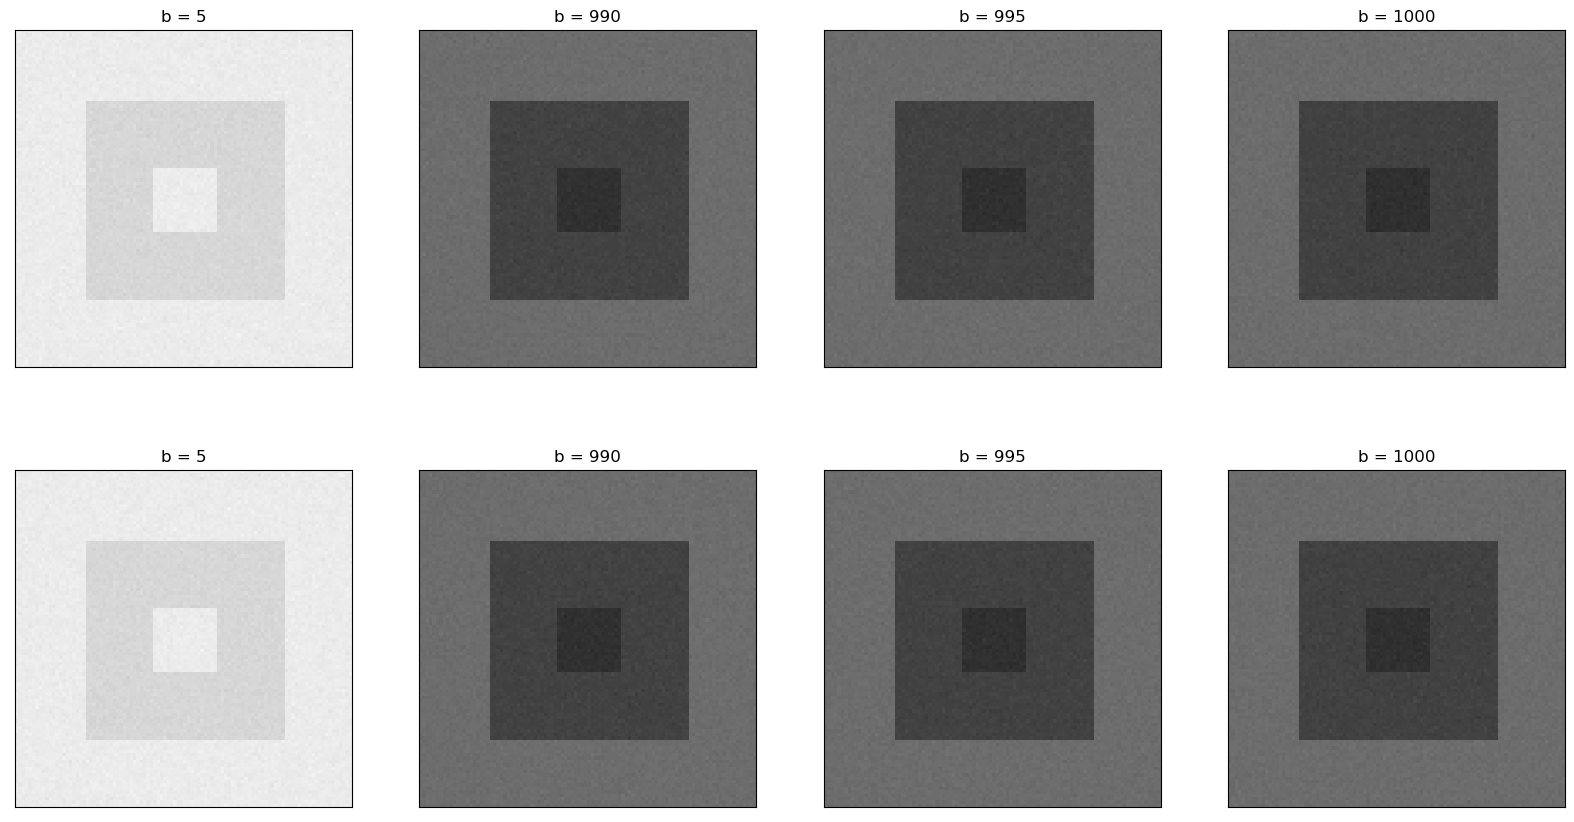

In [14]:
# define parameter values in the three regions
S0_region0, S0_region1, S0_region2 = 1500, 1400, 1600
Dp_region0, Dp_region1, Dp_region2 = 0.02, 0.04, 0.06
Dt_region0, Dt_region1, Dt_region2 = 0.0015, 0.0010, 0.0005
Fp_region0, Fp_region1, Fp_region2 = 0.1, 0.2, 0.3
# image size
sx, sy, sb = 100, 100, len(b_values_simulation)
# create image
dwi_image = np.zeros((sx, sy, sb))
Dp_truth = np.zeros((sx, sy))
Dt_truth = np.zeros((sx, sy))
Fp_truth = np.zeros((sx, sy))
# fill image with simulated values
for i in range(sx):
    for j in range(sy):
        if (40 < i < 60) and (40 < j < 60):
            # region 0
            dwi_image[i, j, :] = S0_region0*ivim(b_values_simulation, Dp_region0, Dt_region0, Fp_region0)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region0, Dt_region0, Fp_region0
        elif (20 < i < 80) and (20 < j < 80):
            # region 1
            dwi_image[i, j, :] = S0_region1*ivim(b_values_simulation, Dp_region1, Dt_region1, Fp_region1)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region1, Dt_region1, Fp_region1
        else:
            # region 2
            dwi_image[i, j, :] = S0_region2*ivim(b_values_simulation, Dp_region2, Dt_region2, Fp_region2)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region2, Dt_region2, Fp_region2
# add some noise
dwi_image_real = dwi_image + np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image_imag = np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image = np.sqrt(dwi_image_real**2 + dwi_image_imag**2)
# plot simulated diffusion weighted image
fig, ax = plt.subplots(2, 4, figsize=(20,20))
b_id = 0
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(dwi_image[:, :, b_id], cmap='gray', clim=(0, 1600))
        ax[i, j].set_title('b = ' + str(b_values_simulation[b_id]))
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        b_id += 1
plt.subplots_adjust(hspace=-0.6)
plt.show()


## Inference

Estimate IVIM parameter values for the simulated image.

In [75]:
# b_values = torch.FloatTensor(bval_list)
net_200_epoch = Net(b_values)
net_200_epoch.load_state_dict(torch.load('model_200epoch.pt'))
net_200_epoch.eval()

Net(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=3, bias=True)
  )
)

In [76]:
dwi_img_pred_train, Dp_train, Dt_train, Fp_train = net_200_epoch(torch.from_numpy(normalized_scan_long_no_background[0:100,:].astype(np.float32)))

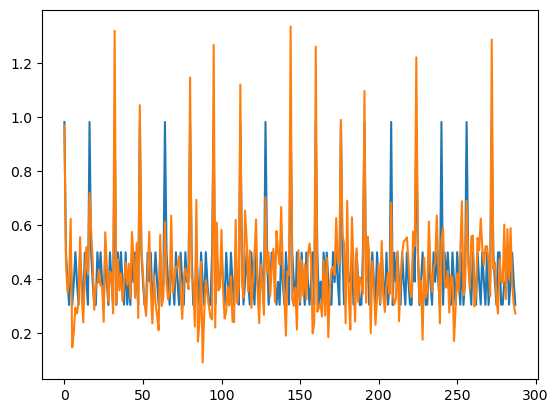

In [85]:
plt.plot(dwi_img_pred_train[3,:].detach().numpy())
plt.plot(normalized_scan_long_no_background[3,:])

In [82]:
dwi_img_pred_train[3,:]

tensor([0.9813, 0.4993, 0.3913, 0.3055, 0.4999, 0.3062, 0.3903, 0.5005, 0.3918,
        0.3059, 0.4993, 0.3922, 0.3062, 0.4987, 0.3913, 0.3062, 0.9813, 0.4999,
        0.3908, 0.3051, 0.3055, 0.4999, 0.3903, 0.4999, 0.3918, 0.3070, 0.4987,
        0.3908, 0.3055, 0.4999, 0.3913, 0.3066, 0.9813, 0.3055, 0.4999, 0.3908,
        0.5005, 0.3918, 0.3066, 0.4999, 0.3070, 0.3913, 0.3055, 0.4999, 0.3903,
        0.4993, 0.3918, 0.3062, 0.9813, 0.4987, 0.3903, 0.3062, 0.3059, 0.4987,
        0.3922, 0.4987, 0.3070, 0.3903, 0.4999, 0.3918, 0.3055, 0.4993, 0.3066,
        0.3908, 0.9813, 0.5005, 0.3903, 0.3062, 0.4993, 0.3903, 0.3059, 0.4999,
        0.3903, 0.3055, 0.4987, 0.3908, 0.3051, 0.5005, 0.3903, 0.3913, 0.9813,
        0.4993, 0.3051, 0.3070, 0.4987, 0.3913, 0.3059, 0.4993, 0.3903, 0.3059,
        0.5005, 0.3903, 0.3066, 0.3059, 0.4993, 0.9813, 0.3066, 0.4999, 0.3913,
        0.3913, 0.4987, 0.3908, 0.3062, 0.4987, 0.3898, 0.3062, 0.4987, 0.3908,
        0.3051, 0.4993, 0.3903, 0.3066, 

In [54]:
# dwi_img_pred_train, Dp_train, Dt_train, Fp_train = net(torch.from_numpy(normalized_scan_long_no_background[]))
torch.from_numpy(normalized_scan_long_no_background[1000,:].astype(np.float32)).shape

torch.Size([288])

In [57]:
torch.from_numpy(normalized_scan_long_no_background[1000,:].astype(np.float32)).shape

torch.Size([288])

In [68]:
dwi_img_pred_train, Dp_train, Dt_train, Fp_train = net(torch.from_numpy(normalized_scan_long_no_background[0:100,:].astype(np.float32)))

In [69]:
dwi_img_pred_train.shape

torch.Size([100, 288])

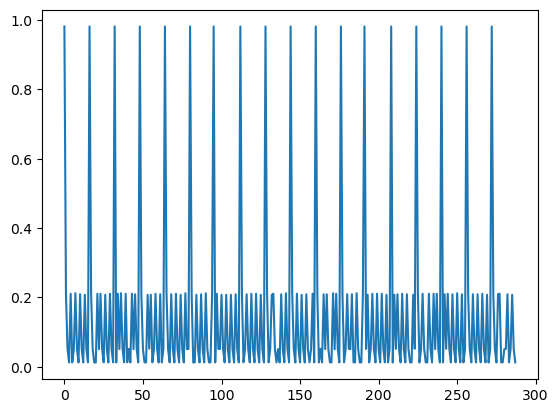

In [70]:
plt.plot(dwi_img_pred_train[0,:].detach().numpy())

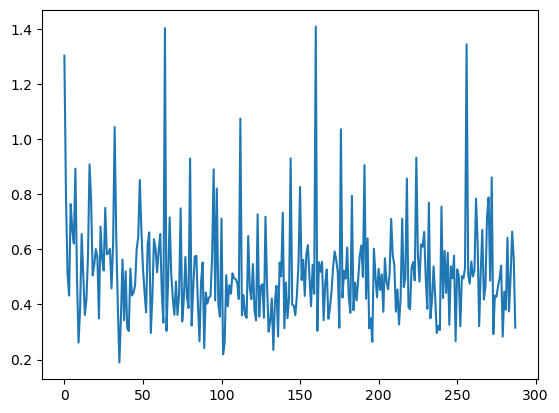

In [71]:
plt.plot(normalized_scan_long_no_background[0,:])

In [55]:
# net.load_state_dict(final_model)
# normalize signal
dwi_image_long = np.reshape(dwi_image, (sx*sy, sb))
S0 = np.expand_dims(dwi_image_long[:,0], axis=-1)
dwi_image_long = dwi_image_long[:,1:]/S0

net.eval()
with torch.no_grad():
    dwi_img_pred, Dp, Dt, Fp = net(torch.from_numpy(dwi_image_long.astype(np.float32)))
    print(torch.from_numpy(dwi_image_long.astype(np.float32)).shape)
    
Dp = Dp.numpy()
Dt = Dt.numpy()
Fp = Fp.numpy()
dwi_img_pred = dwi_img_pred.numpy()

# make sure Dp is the larger value between Dp and Dt
if np.mean(Dp) < np.mean(Dt):
    Dp, Dt = Dt, Dp
    Fp = 1 - Fp

torch.Size([10000, 288])


In [ ]:
dwi_image_long[0,:]

In [ ]:
dwi_img_pred[:,:]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,20))

ax[0].imshow(dwi_image_long, cmap='gray', clim=(0, 0.5))
ax[1].imshow(dwi_img_pred, cmap='gray', clim=(0, 0.05))

plt.subplots_adjust(hspace=-0.6)
plt.show()

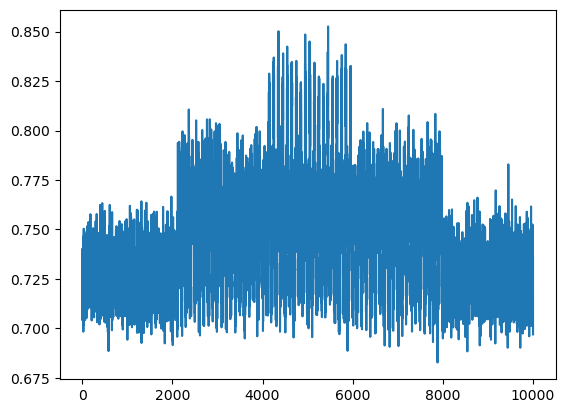

In [47]:
plt.plot(dwi_image_long[:,100])

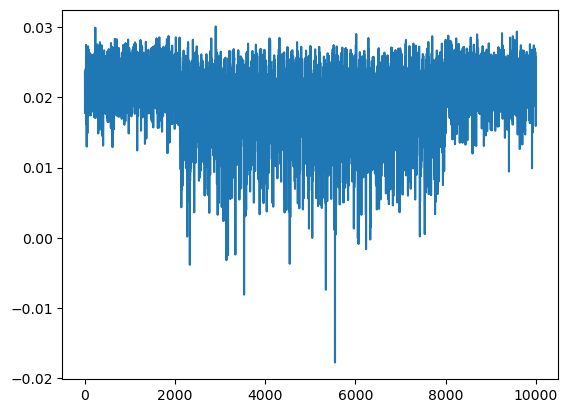

In [48]:
plt.plot(dwi_img_pred[:,100])

Plot parameter estimates and corresponding ground truths.

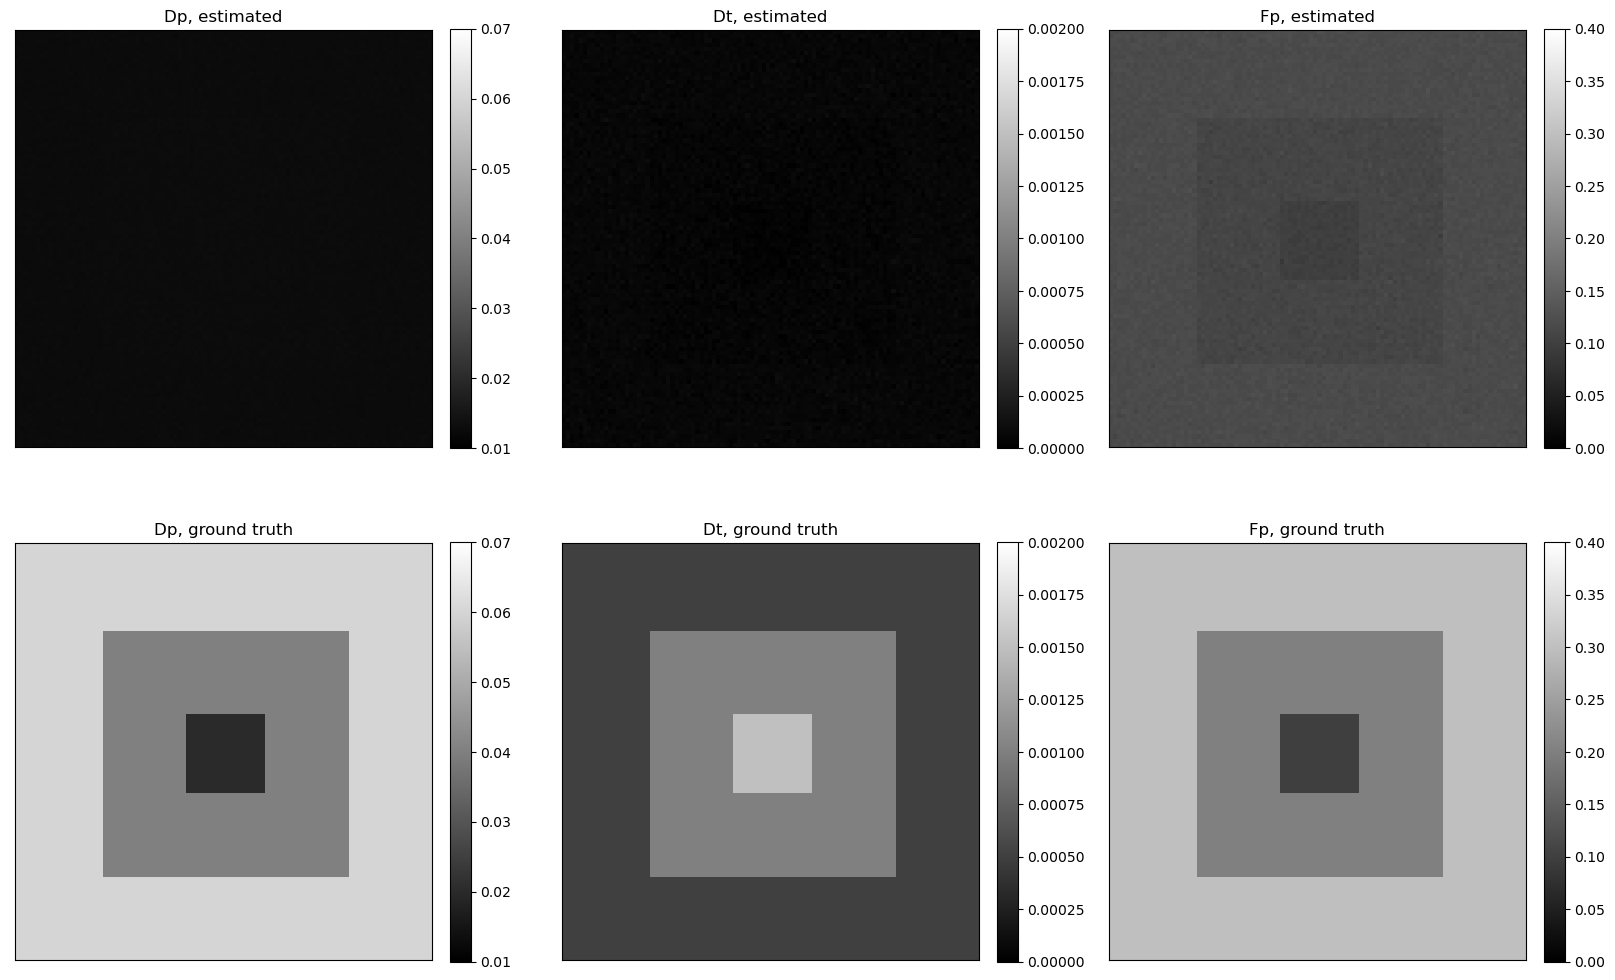

In [59]:
fig, ax = plt.subplots(2, 3, figsize=(20,20))

Dp_plot = ax[0,0].imshow(np.reshape(Dp, (sx, sy)), cmap='gray', clim=(0.01, 0.07))
ax[0,0].set_title('Dp, estimated')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(Dp_plot, ax=ax[0,0], fraction=0.046, pad=0.04)

Dp_t_plot = ax[1,0].imshow(Dp_truth, cmap='gray', clim=(0.01, 0.07))
ax[1,0].set_title('Dp, ground truth')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(Dp_t_plot, ax=ax[1,0], fraction=0.046, pad=0.04)

Dt_plot = ax[0,1].imshow(np.reshape(Dt, (sx, sy)), cmap='gray', clim=(0, 0.002))
ax[0,1].set_title('Dt, estimated')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(Dt_plot, ax=ax[0,1],fraction=0.046, pad=0.04)

Dt_t_plot = ax[1,1].imshow(Dt_truth, cmap='gray', clim=(0, 0.002))
ax[1,1].set_title('Dt, ground truth')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(Dt_t_plot, ax=ax[1,1], fraction=0.046, pad=0.04)

Fp_plot = ax[0,2].imshow(np.reshape(Fp, (sx, sy)), cmap='gray', clim=(0, 0.4))
ax[0,2].set_title('Fp, estimated')
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
fig.colorbar(Fp_plot, ax=ax[0,2],fraction=0.046, pad=0.04)

Fp_t_plot = ax[1,2].imshow(Fp_truth, cmap='gray', clim=(0, 0.4))
ax[1,2].set_title('Fp, ground truth')
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
fig.colorbar(Fp_t_plot, ax=ax[1,2], fraction=0.046, pad=0.04)

plt.subplots_adjust(hspace=-0.5)
plt.show()